# Implementation of Anomaly detection using Autoencoders
Dataset used here is Credit Card Fraud Detection from Kaggle.

### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
RANDOM_SEED = 2021 
TEST_PCT = 0.3
LABELS = ["Normal","Fraud"]

### Read the dataset
I had downloaded the data from Kaggle and stored it in the local directory.

In [2]:
dataset = pd.read_csv("creditcard.csv")

# Exploratory Data Analysis

In [3]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#check for any  nullvalues 
print("Any nulls in the dataset ",dataset.isnull().values.any() )
print('-------')
print("No. of unique labels ", len(dataset['Class'].unique()))
print("Label values ",dataset.Class.unique())
#0 is for normal credit card transaction
#1 is for fraudulent credit card transaction
print('-------')
print("Break down of the Normal and Fraud Transactions")
print(pd.value_counts(dataset['Class'], sort = True) )

Any nulls in the dataset  False
-------
No. of unique labels  2
Label values  [0 1]
-------
Break down of the Normal and Fraud Transactions
0    284315
1       492
Name: Class, dtype: int64


### Visualize the dataset
plotting the number of normal and fraud transactions in the dataset.

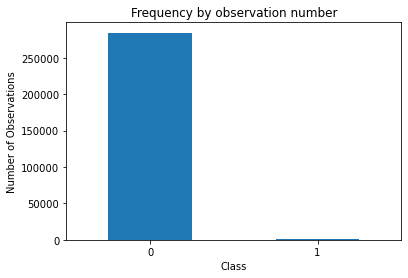

In [5]:
#Visualizing the imbalanced dataset
count_classes = pd.value_counts(dataset['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(len(dataset['Class'].unique())), dataset.Class.unique())
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations")

Visualizing the amount for normal and fraud transactions.

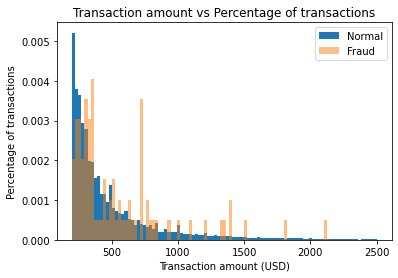

In [6]:
#Save the normal and fradulent transactions in separate dataframe
normal_dataset = dataset[dataset.Class == 0] 
fraud_dataset = dataset[dataset.Class == 1]
#Visualize transactionamounts for normal and fraudulent transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_dataset.Amount, bins=bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_dataset.Amount, bins=bins, alpha=0.5, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Transaction amount vs Percentage of transactions")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions")
plt.show()

### Create train and test dataset
Checking on the dataset

Time and Amount are the columns that are not scaled, so applying StandardScaler to only Amount and Time columns. Normalizing the values between 0 and 1 did not work great for the dataset.

In [7]:
sc=StandardScaler()
dataset['Time'] = sc.fit_transform(dataset['Time'].values.reshape(-1, 1))
dataset['Amount'] = sc.fit_transform(dataset['Amount'].values.reshape(-1, 1))

The last column in the dataset is our target variable.

In [8]:
raw_data = dataset.values
# The last element contains if the transaction is normal which is represented by a 0 and if fraud then 1
labels = raw_data[:, -1]
# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=2021
)

### Normalize the data to have a value between 0 and 1

In [9]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

> Use only normal transactions to train the Autoencoder.

Normal data has a value of 0 in the target variable. Using the target variable to create a normal and fraud dataset.

In [10]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
#creating normal and fraud datasets
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]
fraud_train_data = train_data[train_labels]
fraud_test_data = test_data[test_labels]
print(" No. of records in Fraud Train Data=",len(fraud_train_data))
print(" No. of records in Normal Train data=",len(normal_train_data))
print(" No. of records in Fraud Test Data=",len(fraud_test_data))
print(" No. of records in Normal Test data=",len(normal_test_data))

 No. of records in Fraud Train Data= 389
 No. of records in Normal Train data= 227456
 No. of records in Fraud Test Data= 103
 No. of records in Normal Test data= 56859


### Set the training parameter values

In [11]:
nb_epoch = 50
batch_size = 64
input_dim = normal_train_data.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2=4  
learning_rate = 1e-7

### Create the Autoencoder
The architecture of the autoencoder is shown below.

![esquema](autoencoder.png)

In [12]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(input_dim, ))
#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh",                                activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 14)                434       
_________________________________________________________________
dropout (Dropout)            (None, 14)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 32        
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 35        
_________________________________________________________________
dropout_1 (Dropout)          (None, 7)                 0     

### Define the callbacks for checkpoints and early stopping

In [13]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               mode='min', monitor='val_loss', verbose=2, save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

### Compile the Autoencoder

In [14]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

### Train the Autoencoder

In [15]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_data, test_data),
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history

Epoch 1/50
3554/3554 [==============================] - 27s 7ms/step - loss: 0.0169 - accuracy: 0.0381 - val_loss: 1.9939e-05 - val_accuracy: 0.0111

Epoch 00001: val_loss improved from inf to 0.00002, saving model to autoencoder_fraud.h5
Epoch 2/50
3554/3554 [==============================] - 22s 6ms/step - loss: 1.9723e-05 - accuracy: 0.0650 - val_loss: 1.9934e-05 - val_accuracy: 0.0189

Epoch 00002: val_loss improved from 0.00002 to 0.00002, saving model to autoencoder_fraud.h5
Epoch 3/50
3554/3554 [==============================] - 22s 6ms/step - loss: 1.9169e-05 - accuracy: 0.0630 - val_loss: 2.0216e-05 - val_accuracy: 0.0269

Epoch 00003: val_loss did not improve from 0.00002
Epoch 4/50
3554/3554 [==============================] - 22s 6ms/step - loss: 1.9559e-05 - accuracy: 0.0606 - val_loss: 2.0299e-05 - val_accuracy: 0.0596

Epoch 00004: val_loss did not improve from 0.00002
Epoch 5/50
3554/3554 [==============================] - 24s 7ms/step - loss: 1.9504e-05 - accuracy: 0.05

Plot training and test loss

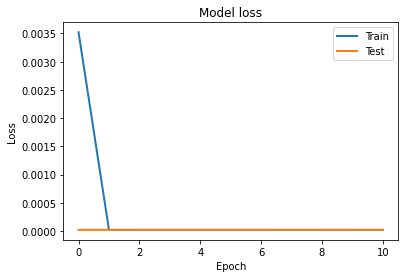

In [16]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

# Detect Anomalies on test data
> Anomalies are data points where the reconstruction loss is higher

To calculate the reconstruction loss on test data, predict the test data and calculate the mean square error between the test data and the reconstructed test data.

In [17]:
test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_labels})

Plotting the test data points and their respective reconstruction error sets a threshold value to visualize if the threshold value needs to be adjusted.

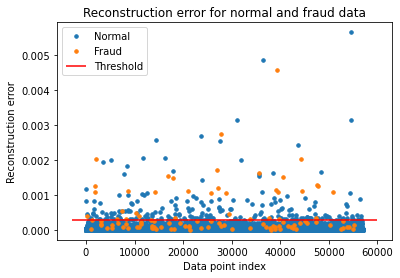

In [21]:
threshold_fixed = 0.0003
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

Detect anomalies as points where the reconstruction loss is greater than a fixed threshold. Here we see that a value of 52 for the threshold will be good.
### Evaluating the performance of the anomaly detection

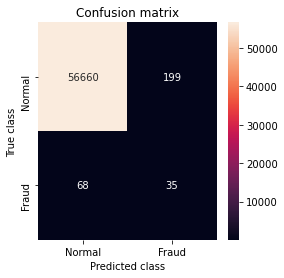

 Accuracy:  0.9953126645834065
 Recall:  0.33980582524271846
 Precision:  0.14957264957264957


In [22]:
threshold_fixed =0.0003
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))

As our dataset is highly imbalanced, we see a high accuracy but a low recall and precision.
Things to further improve precision and recall would add more relevant features, different architecture for autoencoder, different hyperparameters, or a different algorithm.
# Conclusion:
Autoencoder can be used as an anomaly detection algorithm when we have an unbalanced dataset where we have a lot of good examples and only a few anomalies. Autoencoders are trained to minimize reconstruction error. When we train the autoencoders on normal data or good data, we can hypothesize that the anomalies will have higher reconstruction errors than the good or normal data.